In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
df = pd.read_csv('final_features.csv')
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,...,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,...,92,100,93,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557
1,1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,...,82,91,64,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655
2,2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,...,80,67,67,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306
3,3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,...,29,28,25,0.650411,15.987437,1.0,192.237828,1.140536,0.506028,0.692421
4,4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,...,71,63,48,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633


In [3]:
df.drop(['Unnamed: 0','id','qid1','qid2','question1','question2'],axis = 1,inplace = True)
df.head(2)

,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,47,41,5,93,98,100,92,100,93,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557
1,0,41,77,3,66,85,100,82,91,64,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655


In [4]:
df.shape

(404290, 17)

In [5]:
df.dropna(axis = 0,inplace = True)

### Custom plotting matrices using confusion matrix

#### i) Calculate the confusion matrix C.
#### ii) Calculate the precision matrix B and recall matrix A using the confusion matrix.
#### iii) Plot the confusion matrix, precision matrix, and recall matrix using seaborn's heatmap.
#### iv) Display the plots in a single figure with appropriate titles and labels.

In [43]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Features and Labels Selection for model training

In [6]:
X = df.iloc[:,1:]
y = df['is_duplicate']

### Model Training

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,shuffle = True)

X_train.shape,X_test.shape



D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


((363397, 16), (40378, 16))

In [12]:
y_train.shape,y_test.shape

((363397,), (40378,))

### Learning Model - Logistic Regression 

### Model training and Loss check

In [20]:
alpha = [0.001,0.01,0.1,1,2,10]
log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="isotonic")
    sig_clf.fit(X_train, y_train)
    
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  0.001 The log loss is: 0.5202778996943709
For values of alpha =  0.01 The log loss is: 0.5190630922642201
For values of alpha =  0.1 The log loss is: 0.5282913429630791
For values of alpha =  1 The log loss is: 0.5366288250090943
For values of alpha =  2 The log loss is: 0.5378705144804355
For values of alpha =  10 The log loss is: 0.5665950023522268



#### Plotting the loss values


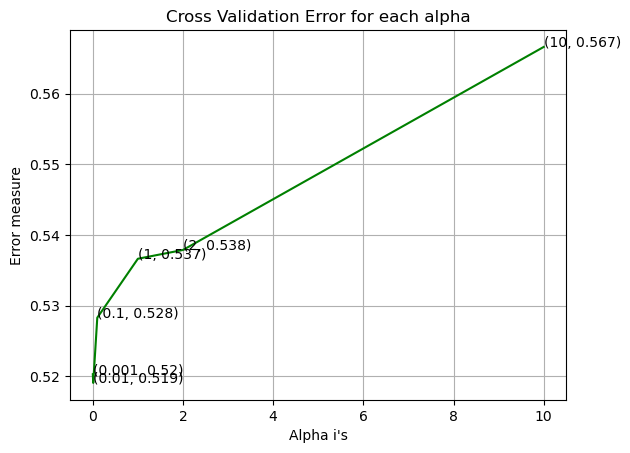

In [25]:

#plot of alpha vs Hinge-loss    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


### Best alpha value selection and model fitting

In [26]:

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)



CalibratedClassifierCV(estimator=SGDClassifier(alpha=0.01, penalty='l1',
                                               random_state=42))

### Printing log loss, accuracy, classification report and confusion matrix

In [30]:
predict_y = sig_clf.predict_proba(X_train)

print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)

For values of best alpha = 0.01 The train log loss is: 0.5375267141359762


In [29]:
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)

For values of best alpha = 0.01 The test log loss is: 0.5388491074973352


In [31]:
print("Total number of data points :", len(predicted_y))
print('-----------------------------------------------------------------------')
print(accuracy_score(y_test, predicted_y))
print(classification_report(y_test, predicted_y))

Total number of data points : 40378
-----------------------------------------------------------------------
0.6757392639556195
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     25459
           1       0.57      0.51      0.54     14919

    accuracy                           0.68     40378
   macro avg       0.65      0.64      0.64     40378
weighted avg       0.67      0.68      0.67     40378



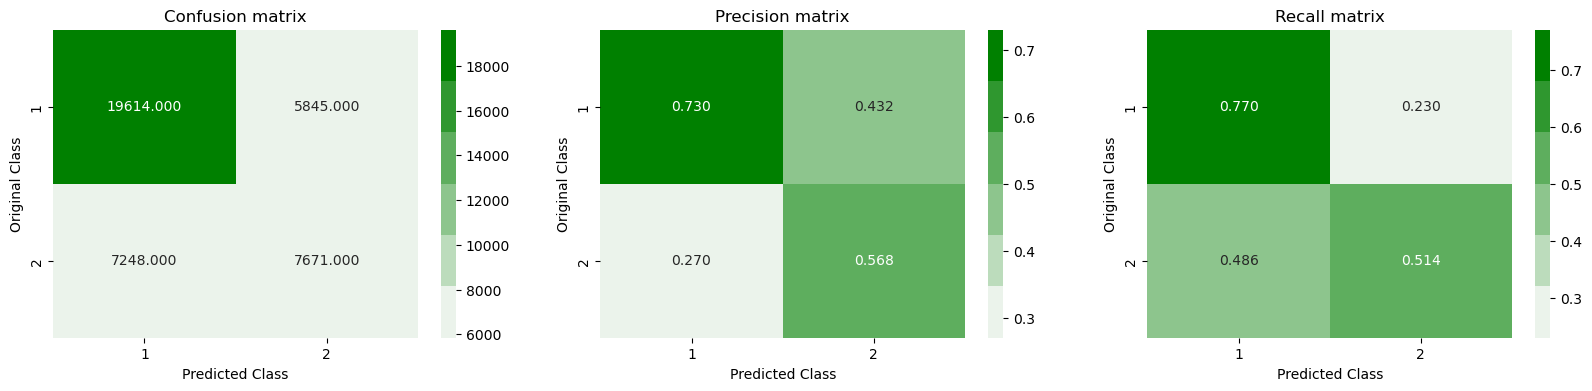

In [44]:
plot_confusion_matrix(y_test, predicted_y)

In [45]:
print(accuracy_score(y_test, predicted_y))

0.6757392639556195


### Testing...

In [63]:
da = X_test.iloc[:1]
da

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
17094,33,28,3,69,61,100,67,68,61,0.232904,9.280491,1.0,135.823171,0.682501,0.30986,0.358645


In [62]:
X_test.iloc[:1]

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
17094,33,28,3,69,61,100,67,68,61,0.232904,9.280491,1.0,135.823171,0.682501,0.30986,0.358645


In [60]:
y_test.iloc[1]

0

In [64]:
res = sig_clf.predict(da)
res

array([0], dtype=int64)

### Learning Model - SVM 

### Model training and Loss check

In [65]:
alpha = [0.001,0.01,0.1,1,2,10]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="isotonic")
    sig_clf.fit(X_train, y_train)
    
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  0.001 The log loss is: 0.5202778996943709
For values of alpha =  0.01 The log loss is: 0.5190630922642201
For values of alpha =  0.1 The log loss is: 0.5282913429630791
For values of alpha =  1 The log loss is: 0.5366288250090943
For values of alpha =  2 The log loss is: 0.5378705144804355
For values of alpha =  10 The log loss is: 0.5665950023522268


### Plotting the log loss values

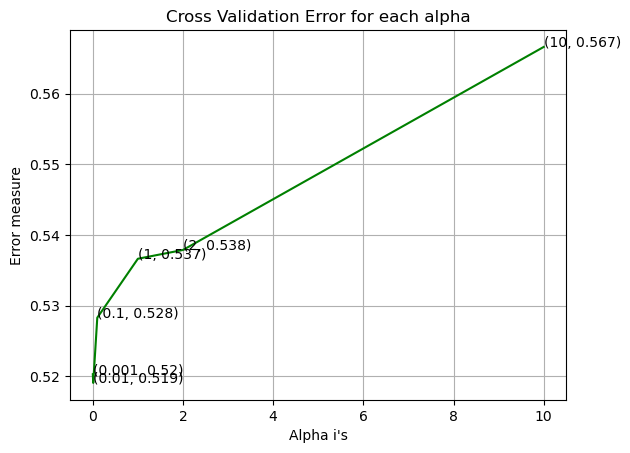

In [66]:

#plot of alpha vs Hinge-loss    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')

for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


### Best Alpha selection and model fitting

In [67]:

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_train)


### Printing log loss, accuracy, classification report and confusion matrix

In [68]:

print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)

print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)



For values of best alpha =  0.01 The train log loss is: 0.5375267141359762
For values of best alpha =  0.01 The test log loss is: 0.5388491074973352


In [69]:
print("Total number of data points :", len(predicted_y))
print('-----------------------------------------------------------------------')
print(accuracy_score(y_test, predicted_y))
print(classification_report(y_test, predicted_y))

Total number of data points : 40378
-----------------------------------------------------------------------
0.6757392639556195
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     25459
           1       0.57      0.51      0.54     14919

    accuracy                           0.68     40378
   macro avg       0.65      0.64      0.64     40378
weighted avg       0.67      0.68      0.67     40378



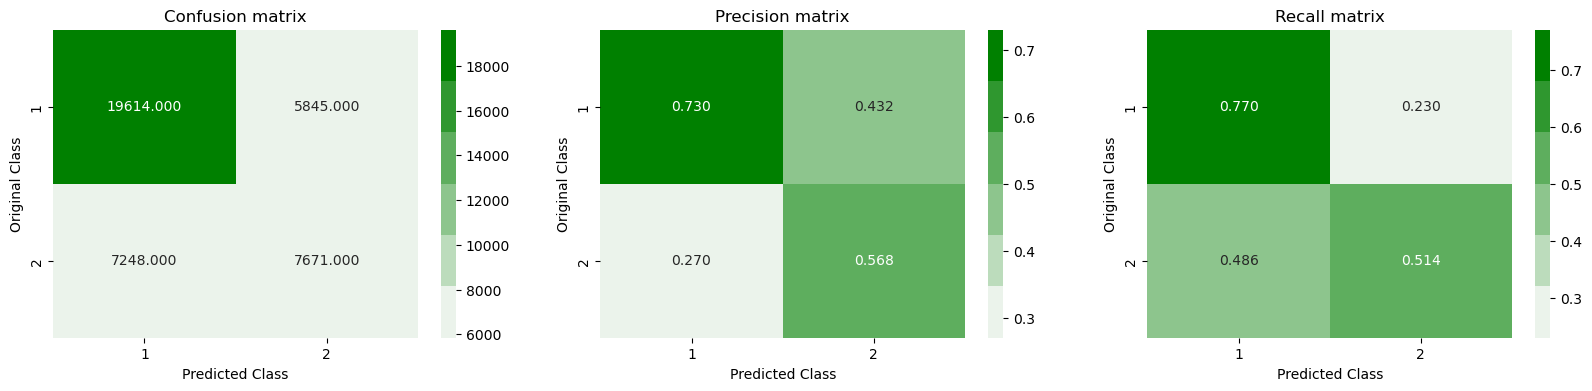

In [70]:
plot_confusion_matrix(y_test, predicted_y)

In [74]:
print(accuracy_score(y_test, predicted_y))

0.6757392639556195


### Testing...

In [71]:
da = X_test.iloc[:1]
da

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
17094,33,28,3,69,61,100,67,68,61,0.232904,9.280491,1.0,135.823171,0.682501,0.30986,0.358645


In [72]:
X_test.iloc[:1]

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
17094,33,28,3,69,61,100,67,68,61,0.232904,9.280491,1.0,135.823171,0.682501,0.30986,0.358645


In [60]:
y_test.iloc[1]

0

In [73]:
res = sig_clf.predict(da)
res

array([0], dtype=int64)